# pipelines

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
#setup enviroment

!git clone https://github.com/suayder/computer_vision_eps_usp.git -b EP3
%cd computer_vision_eps_usp
%pip install -r requirements.txt
%load_ext google.colab.data_table

In [ ]:
import os
import math
import random
import numpy as np
import pandas as pd
from skimage import io
from genericpath import exists
from matplotlib import pyplot as plt
from skimage.transform import resize
from skimage import img_as_uint, measure
from skimage.exposure import rescale_intensity
from src.augmenter import Transform, Augmenter
from src.transform.img_transformers import Rgb2Gray, LogTransform, ExpTransform, ImageEqualization, Resize
from src.data_reader import ObjectDataset
from src.utils import read_img, display_bbox,crop_bbox, display
from src.segment import object_segmentation, get_bbox
from src.classifier import SVMClassifier
from src.metrics import classification_metrics, segmentation_metrics

#the image will be resized for this size
DEFAULT_SIZE = (512,512)
#the bounding box will be resized for this size
BBOX_SIZE = (256,256)
TRAIN_SPLIT = 0.8
BASE_PATH = '/gdrive/MyDrive/MAC5768-visao_e_processamento_de_imagens/dataset/original_dataset_gray'
CSV_PATH = os.path.join(BASE_PATH, 'metadata.csv')
IMGS_PATH = os.path.join(BASE_PATH,'data')
MASKS_PATH = '/gdrive/MyDrive/MAC5768-visao_e_processamento_de_imagens/dataset/masks'
LIST_MASKS = os.path.join(MASKS_PATH,'manualy_seg.csv')
DST_SEG = '/gdrive/MyDrive/MAC5768-visao_e_processamento_de_imagens/dataset/automatic_segmented'

### utils functions

In [ ]:
def read_dset(obj_dataset, element):

    image, img_class = obj_dataset.get_item(element,cache=False)
    image = img_as_uint(resize(image, DEFAULT_SIZE))
    return image, img_class

def preprocess_dataset(image:np.ndarray):

    image = rescale_intensity(image, in_range=(50, 200))
    image = img_as_uint(resize(image, DEFAULT_SIZE))
    return image

def load_dataset(elements, crop=True):
    obj_dataset = ObjectDataset(IMGS_PATH, CSV_PATH)

    X = []
    y = []
    for element in elements:
        try:
          image, img_class = read_dset(obj_dataset, element)
        except KeyError:
          continue

        if crop:
          bb = get_bbox(image)
          X.append(crop_bbox(image, bb))
        else:
          X.append(image)
        y.append(img_class)

    #resize images if the bounding box where croped
    if crop:

      X = [img_as_uint(resize(img, BBOX_SIZE)) for img in X]

    return np.array(X), np.array(y)

def read_dataset_from_csv():
    """
    this time we use the csv file to have a list of all images that we whant to
    train or predict, it return a list of splited images
    """
    
    names = np.loadtxt(LIST_MASKS, dtype=str, delimiter=',')
    names = np.array(list(map(lambda s: s.replace("'",''), names)))

    print("Size of the dataset:", len(names))
    #print(f"train split with {t_size} images\ntest split with {(len(names)-t_size)} images")
    return names

## Segmentation Pipeline

Basicaly get one image and segment it returning the image and bounding box for it.

In [ ]:
def seg_pipeline(image, is_binary=False, show=True):
    """
    args:
        image: can be the path to the image or a np array corresponding to the images
    """

    if isinstance(image,str):
        image = read_img(image, as_gray=True)

    image = preprocess_dataset(image)
    segmented = object_segmentation(image) if not is_binary else image
    
    bbox = get_bbox(segmented)

    if show:
        display_bbox(image, bbox)
        plt.show()

    return segmented, bbox

In [ ]:
data_p = ObjectDataset(IMGS_PATH, CSV_PATH)

In [ ]:
# Segment and save all images in the dataset
names =read_dataset_from_csv()
for name in names:
  try:
    img,_ = data_p.get_item(name, cache=False)
    segmented, bbox = seg_pipeline(img, show=False)

    io.imsave(os.path.join(DST_SEG, name), segmented)
  except KeyError:
    continue
print(f'everything saved on {DST_SEG}')

Size of the dataset: 172


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: /gdrive/MyDrive/MAC5768-visao_e_processamento_de_imagens/dataset/automatic_segmented/gray_480.JPEG is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: /gdrive/MyDrive/MAC5768-visao_e_processamento_de_imagens/dataset/automatic_segmented/gray_501.JPEG is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: /gdrive/MyDrive/MAC5768-visao_e_processamento_de_imagens/dataset/automatic_segmented/gray_483.JPEG is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: /gdrive/MyDrive/MAC5768-visao_e_processamento_de_imagens/dataset/automatic_segmented/gray_499.JPEG is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: /gdrive/MyDrive/MAC5768-visao_e_processamento_de_imagens/dataset/automatic_segmented/gray_496.JPEG is a low con

everything saved on /gdrive/MyDrive/MAC5768-visao_e_processamento_de_imagens/dataset/automatic_segmented


# some examples

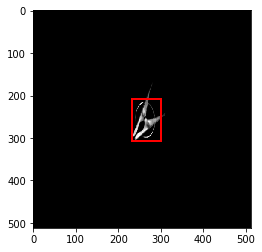

In [ ]:
img,_ = data_p.get_item('gray_999.jpg', cache=False)
segmented, bbox = seg_pipeline(img, show=True)

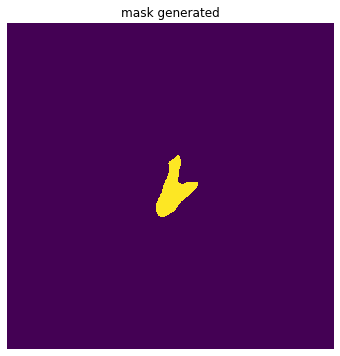

In [ ]:
display([segmented], titles=['mask generated'], figsize=(8,6))

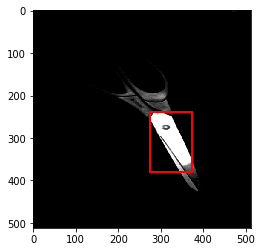

In [ ]:
img,_ = data_p.get_item('gray_744.jpg', cache=False)
segmented, bbox = seg_pipeline(img, show=True)

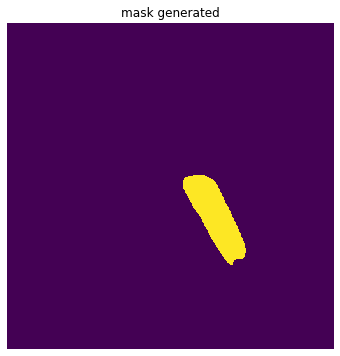

In [ ]:
display([segmented], titles=['mask generated'], figsize=(8,6))

### Metrics for segmentation

In [ ]:
#read segmented and manual segmented

data_obj = ObjectDataset(MASKS_PATH, CSV_PATH)
images_names = read_dataset_from_csv()

ground_truth = []
segmented = []

for names in images_names:
  try:
    image, _ = data_obj.get_item(names)
  except KeyError:
    continue
  image = image>127
  image = img_as_uint(resize(image, DEFAULT_SIZE))
  ground_truth.append(image)

  seg = io.imread(os.path.join(DST_SEG, names))>127
  segmented.append(seg)

Size of the dataset: 172


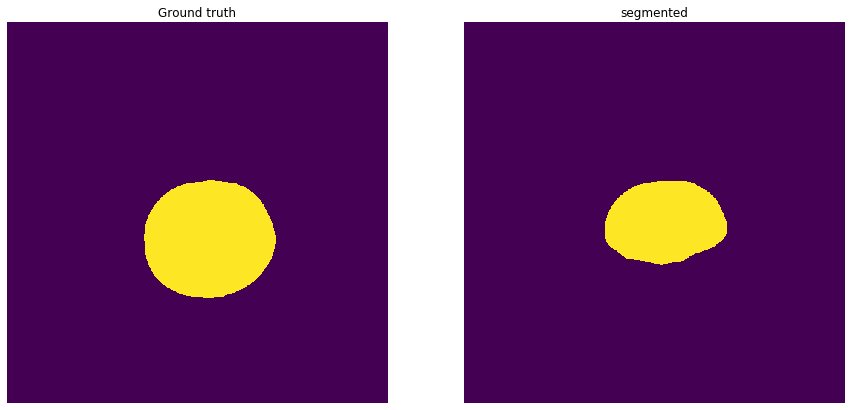

In [ ]:
display([ground_truth[0], segmented[0]], titles=["Ground truth", "segmented"])

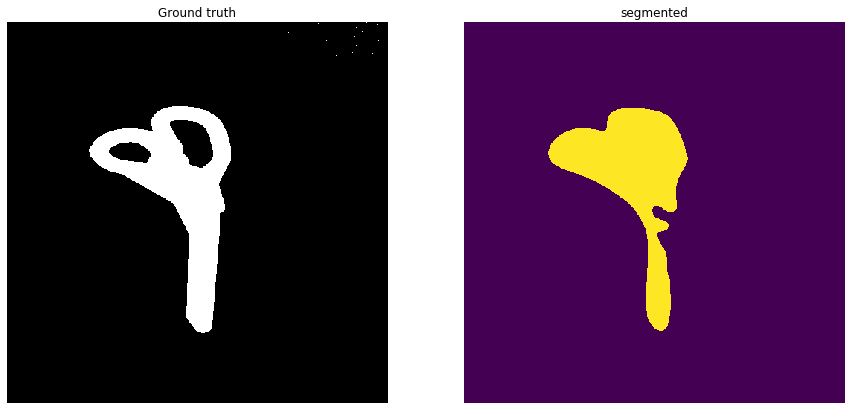

In [ ]:
display([ground_truth[100], segmented[100]], titles=["Ground truth", "segmented"])

In [ ]:
def segmentation_metrics(y_true, y_pred):

    prec = 0
    recall = 0
    cont = 0
    for i, j in zip(y_true, y_pred):
        try:
          p,r = avalia_segm(i,j)
          prec +=p
          recall+=r
          cont+=1
        except ValueError:
          continue

    prec = prec/cont
    recall = recall/cont
    print("METRICS RESULTS:\n")
    print(f"\tprecision: {prec}")
    print(f"\treccall of the segmentation: {recall}")
segmentation_metrics(ground_truth, segmented)

METRICS RESULTS:

	precision: 0.5758390769947669
	reccall of the segmentation: 0.8002268693506877


# Classification pipeline

This model was trained using SVM and PCA for dimensionality reducion

> The dataset was splited into train and test data, in the train data we have used 80% of the dataset and the other 20% in the test set.

> Basicaly we have used the num of feature to pca setted as 15 and trained svm for a classification task, the results are printed bellow:

In [ ]:
def train_classifier(train_split=None):

    #split datset into train and test
    if train_split is None:
      train_split = read_dataset_from_csv()

    X_train, y_train = load_dataset(train_split)
    svm = SVMClassifier(DEFAULT_SIZE, 2)
    y_train = (y_train[np.newaxis,...]).reshape((X_train.shape[0],1))
    svm.fit(X_train, y_train)

    return svm


def classification_metrics_pipe():

    data_p = ObjectDataset(IMGS_PATH, CSV_PATH)
    names = data_p.get_all_names()
    random.shuffle(names)
    train_split = names[int(len(names)*0.8):]
    test_split = names[:int(len(names)*0.8)]
    svm = train_classifier(train_split)
    
    X_test, y_test = load_dataset(test_split)
    segmented_images = []
    for img in X_test:
      segmented, bbox = seg_pipeline(img,show=False)
      segmented_images.append(segmented)

    #print(np.expand_dims(segmented_images, axis=0).shape)
    y_pred = svm.predict(segmented_images)
    classification_metrics(y_test,y_pred)

classification_metrics_pipe()

PCA fitted
SVM fitted


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


METRICS RESULTS:

	Accuracy: 0.68
	F1-score: 0.63
